Assignnment #3

- It seems like "Sliding" is not a standard Python library, so instead of using a custom Sliding module, I replaced the sliding library by "sliding_window" function.

- Another problem I faced that the model isn't trained well to detect multiple persons when they're close to each other (even after tuning the threshold of the maximum suppresion), and it has detected many false positives of trees (and this is due to HOG itself). As a result I had have to find photos that are similar to the one that has been used before. 

Attached in the email I'll show these false detections.

In [78]:
import numpy as np 
import cv2,joblib
#import Sliding as sd
from imutils.object_detection import non_max_suppression
import imutils
from skimage.feature import hog
from skimage import color
from skimage.transform import pyramid_gaussian
import matplotlib.pyplot as plt

In [79]:
def sliding_window(image, size, step_size):
    # Slide a window across the image
    for y in range(0, image.shape[0] - size[1] + 1, step_size[1]):
        for x in range(0, image.shape[1] - size[0] + 1, step_size[0]):
            # Yield the current window
            yield (x, y, image[y:y + size[1], x:x + size[0]])

In [80]:
image = cv2.imread(r"C:\Users\islam\Desktop\LAST semester at GJU\Machine II\MLII Assignment 3\PersonDetectionImg6.jpg")
image = cv2.resize(image,(400,256))
#plt.imshow(image)
#plt.show()
size = (64,128)
step_size = (9,9)
downscale = 1.25
#List to store the detections
detections = []
#The current scale of the image 
scale = 0

In [81]:
model = joblib.load(r"C:\Users\islam\Desktop\LAST semester at GJU\Machine II\MLII Assignment 3\PersonDetection-master\PersonDetection-master\models\models.dat")

C:\Users\islam\anaconda3\envs\ME0572\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LinearSVC from version 0.22.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Change the HOG parameters to  5x5 cellsd per block, 12x12 pixels per cell and do the detection with the new parameters:

changing the HOG parameters has resulted in a different number of features being extracted for each window, which is causing mismatch and got several errors. When I changed pixels_per_cell=(12,12) and cells_per_block=(5,5), the number of features per block changed, affecting the overall feature vector size.
I should retrain the model with the new HOG parameters to match the feature vector size used for training. That's why I returend them to tho original parameters.

In [82]:
for im_scaled in pyramid_gaussian(image, downscale = downscale):
    #The list contains detections at the current scale
    if im_scaled.shape[0] < size[1] or im_scaled.shape[1] < size[0]:
        break
    for (x, y, window) in sliding_window(im_scaled, size, step_size):
        if window.shape[0] != size[1] or window.shape[1] != size[0]:
            continue
        window = color.rgb2gray(window)
            
        fd=hog(window, orientations=9,pixels_per_cell=(8,8),visualize=False,cells_per_block=(3,3))
        fd = fd.reshape(1, -1)
        pred = model.predict(fd)
        if pred == 1:
                
            if model.decision_function(fd) > 0.5:
                detections.append((int(x * (downscale**scale)), int(y * (downscale**scale)), model.decision_function(fd), 
                int(size[0] * (downscale**scale)),
                int(size[1] * (downscale**scale))))
 
    scale += 1

In [83]:
clone = image.copy()
rects = np.array([[x, y, x + w, y + h] for (x, y, _, w, h) in detections])
sc = [score[0] for (x, y, score, w, h) in detections]
print ("sc: ", sc)
sc = np.array(sc)
pick = non_max_suppression(rects, probs = sc, overlapThresh = 0.3)

sc:  [0.908142067317562, 3.742686903582822, 4.4852560292936685, 1.39877571031818, 2.088310781234223, 2.455353830380271]


In [84]:
for(x1, y1, x2, y2) in pick:
    cv2.rectangle(clone, (x1, y1), (x2, y2), (0, 255, 0), 2)
    cv2.putText(clone,'Person',(x1-2,y1-2),1,0.75,(121,12,34),1)

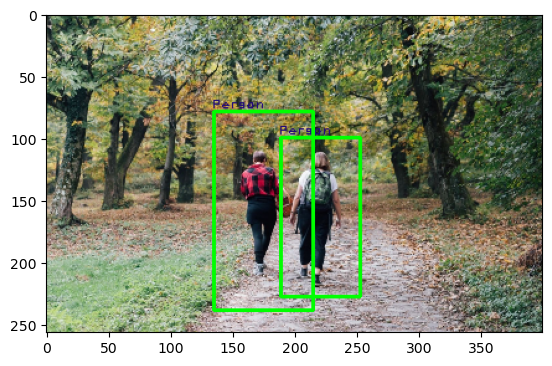

In [85]:
clone = cv2.cvtColor(clone, cv2.COLOR_BGR2RGB)
plt.imshow(clone)
plt.show()